## Model the NPR articles with Latent Dirichlet Allocation

  1. Run the LDA model with sklearn (http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)
  2. Visualize it with pyldavis (https://pyldavis.readthedocs.io/en/latest)

In [1]:
# USE Python3
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.enable_notebook()

df = pd.read_csv('npr_articles.csv', parse_dates=['date_published'])
text = df['processed_text'].values.tolist()

/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/dist-packages/funcy/decorators.py:56: DeprecationW

## Vectorize the words

Essentially create a numeric representation of the words based on frequencies

In [2]:
max_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=max_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(text)
print("ready")

ready


## Run LDA

In [3]:
n_topics = 20
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     26.998926        1       1 -0.021312 -0.002677
7      16.147538        1       2 -0.037740  0.018163
18     12.373197        1       3 -0.106548  0.023222
8      11.035448        1       4 -0.043857  0.029332
14      6.357390        1       5 -0.026214  0.001258
1       4.782389        1       6 -0.097938 -0.016917
5       4.524583        1       7 -0.052184  0.000926
16      3.455316        1       8 -0.087590 -0.001093
17      3.205244        1       9 -0.113015  0.009654
10      1.938333        1      10 -0.081144 -0.018366
13      1.872789        1      11 -0.126876 -0.028426
19      1.652533        1      12  0.138599 -0.065904
9       1.366200        1      13  0.034310 -0.040788
3       1.282585        1      14 -0.061110 -0.085170
12      1.140672        1      15  0.313101 -0.225311
0       1.080769        1      16 -0.054081  0.031813
2       0.472345        1      17  0.241392  0.370867
4       0.243315        1      18  0.211298 -0.058588
6       0.035215        1      19 -0.017464  0.028081
11      0.035215        1      20 -0.011626  0.029925, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
592   Default   3134.000000             npr   3134.000000  20.0000  20.0000
780   Default  10309.000000             say  10309.000000  19.0000  19.0000
193   Default   2117.000000       copyright   2117.000000  18.0000  18.0000
937   Default   2519.000000           trump   2519.000000  17.0000  17.0000
669   Default   2142.000000       president   2142.000000  16.0000  16.0000
582   Default   1773.000000             new   1773.000000  15.0000  15.0000
964   Default    654.000000            vote    654.000000  14.0000  14.0000
741   Default   1748.000000          report   1748.000000  13.0000  13.0000
761   Default   1096.000000           right   1096.000000  12.0000  12.0000
466   Default    861.000000             job    861.000000  11.0000  11.0000
404   Default    903.000000          health    903.000000  10.0000  10.0000
571   Default    733.000000           music    733.000000   9.0000   9.0000
629   Default   3333.000000          people   3333.000000   8.0000   8.0000
889   Default    839.000000            talk    839.000000   7.0000   7.0000
223   Default    950.000000             day    950.000000   6.0000   6.0000
138   Default    492.000000           china    492.000000   5.0000   5.0000
663   Default    493.000000           power    493.000000   4.0000   4.0000
525   Default   3049.000000            make   3049.000000   3.0000   3.0000
723   Default    494.000000          record    494.000000   2.0000   2.0000
356   Default    576.000000            food    576.000000   1.0000   1.0000
33     Topic1    352.018008           album    354.142554   1.3034  -5.4939
839    Topic1    546.521544            song    551.218564   1.3008  -5.0540
392    Topic1    125.425262          guitar    127.511891   1.2929  -6.5259
76     Topic1    303.668686            band    308.805042   1.2926  -5.6416
826    Topic1    144.445163          singer    147.558093   1.2881  -6.3847
825    Topic1    207.411130            sing    211.896361   1.2880  -6.0229
465    Topic1    127.964337            jazz    131.708622   1.2805  -6.5058
571    Topic1    705.314473           music    733.553268   1.2701  -4.7989
573    Topic1    126.128194        musician    132.715239   1.2585  -6.5203
520    Topic1    600.026122            love    647.969998   1.2325  -4.9606
...       ...           ...             ...           ...      ...      ...
881   Topic20      0.126597       supporter    130.288094   1.0150  -6.7822
500   Topic20      0.120771             lie    122.075778   1.0330  -6.8293
771   Topic20      0.226206            rule    369.150242   0.5540  -6.2018
573   Topic20      0.125491      

In [4]:
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)

In [5]:
## get the token to topic matrix
word_topic = np.zeros((max_features,n_topics),)
print(n_topics)
lda_model.components_
for topic_idx, topic in enumerate(lda_model.components_):
    word_topic[:,topic_idx] = topic

print("token-topic matrix",word_topic.shape)

## create a matrix of the top words used to define each topic
top_words = 15
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
top_words = get_top_words(lda_model,tf_feature_names,top_words)
all_top_words = np.array(list(set().union(*[v for v in top_words.values()])))

for key,vals in top_words.items():
    print(key," ".join(vals))
print("total words: %s"%len(all_top_words))

top_word_inds = [np.where(tf_feature_names == tw)[0][0] for tw in all_top_words]

20
token-topic matrix (1000, 20)
18 say school student study state people use child help work high program make parent research
10 china say chinese company market price product ship trade consumer new make industry npr accord
14 trump president russia say intelligence russian elect business company think conflict deal administration secretary country
11 new rule year administration say pay time feel obama npr make way world report issue
3 rate park area report increase population say high accord rise number people california bear rural
13 job tax worker refugee economy growth income americans economic wage work pay labor cut obama
19 film day game tv series movie episode plane culture team small flight star copyright podcast
9 christmas tree car holiday word drive answer npr letter challenge copyright listener tradition sign year
7 say trump president obama election npr elect state campaign news make people time report donald_trump
12 npr copyright now8216s 8212 talk robin_young speak

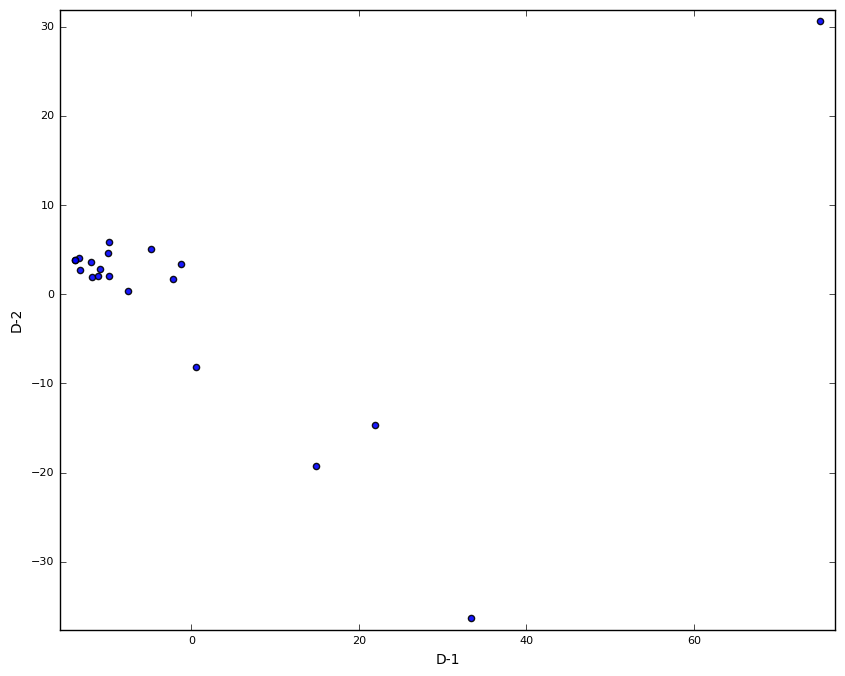

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

def make_scatter(fit,ax,pcX=0,pcY=1,font_size=10,font_name='sans serif',ms=20,leg=True,title=None):
    colors = ['k','cyan','r','orange','g','b','magenta']
    lines = []
    indices = np.arange(fit.shape[0])
    s = ax.scatter(fit[indices,pcX],fit[indices,pcY],s=ms,alpha=0.9)
    lines.append(s)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(font_size-2)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(font_size-2)

    buff = 0.02
    bufferX = buff * (fit[:,pcX].max() - fit[:,pcX].min())
    bufferY = buff * (fit[:,pcY].max() - fit[:,pcY].min())
    ax.set_xlim([fit[:,pcX].min()-bufferX,fit[:,pcX].max()+bufferX])
    ax.set_ylim([fit[:,pcY].min()-bufferY,fit[:,pcY].max()+bufferY])
    ax.set_xlabel("D-%s"%str(pcX+1),fontsize=font_size,fontname=font_name)
    ax.set_ylabel("D-%s"%str(pcY+1),fontsize=font_size,fontname=font_name)
    plt.locator_params(axis='x',nbins=5)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

mat = word_topic
matScaled = preprocessing.scale(mat.T)
pca_fit = PCA(n_components=2).fit_transform(matScaled)

make_scatter(pca_fit,ax)
plt.show()